In [1]:
import os.path
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from tqdm import tqdm
import numpy as np

from utils import RawDataset, EncodedDataset, load_data, split_data

if torch.cuda.is_available():
    device = torch.device("cuda")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    device = torch.device("cpu")
print("Device:", device)

Tesla T4
Device: cuda


Loading the data set

In [2]:
# Use this if using Colab
from google.colab import drive
drive.mount('/content/drive')
base_dir = "/content/drive/MyDrive/data/power"

# Use this if running locally
# base_dir = "data/power/"

Mounted at /content/drive


In [3]:


full_data = load_data(base_dir, ["power-gb-train.tsv", "power-ua-train.tsv"], text_head='text_en')

training_raw, test_raw = split_data(full_data, test_size=0.2, random_state=0)


class ParliamentData(Dataset):
    def __init__(self, data: RawDataset, transform: None):
        self.texts = data.texts
        self.labels = data.labels
        self._transform = transform

    def __getitem__(self, index: int):
        ret = {'text': self.texts[index], 'label': self.labels[index]}
        if self._transform is None:
            return ret
        else:
            return self._transform(ret)

    def __len__(self):
        return len(self.labels)


Load power-gb-train.tsv...
Load power-ua-train.tsv...


Create vocabulary

In [4]:
from nltk.tokenize import wordpunct_tokenize

class Tokenize(object):
    def __call__(self, data):
        text, label = data['text'], data['label']
        return {'text': [word.lower() for word in wordpunct_tokenize(text)],
                'label': label}

training_data = ParliamentData(training_raw, Tokenize())
test_data = ParliamentData(test_raw, Tokenize())

print("Loading training data...", end="")
dataset_vocab = set()
for sample in training_data:
    sample_tokens = set(sample['text'])
    dataset_vocab.update(sample_tokens)
print("done")

print("Loading test data...", end="")
for sample in test_data:
    sample_tokens = set(sample['text'])
    dataset_vocab.update(sample_tokens)
print("done")

print("Found %i tokens in the dataset" % len(dataset_vocab))

Loading training data...done
Loading test data...done
Found 78231 tokens in the dataset


## Word embedding

We need a word embedding

In [6]:
from google.colab import drive

drive.mount('/content/drive')
base_glove = "/content/drive/MyDrive/data/glove/"
assert os.path.exists(base_glove)

!mkdir .vector_cache
!cp /content/drive/MyDrive/data/glove/glove.6B.zip .vector_cache/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘.vector_cache’: File exists


100%|█████████▉| 399999/400000 [00:28<00:00, 13837.85it/s]


400000 words in GloVe
78231 words in the dataset
60350 overlapping words


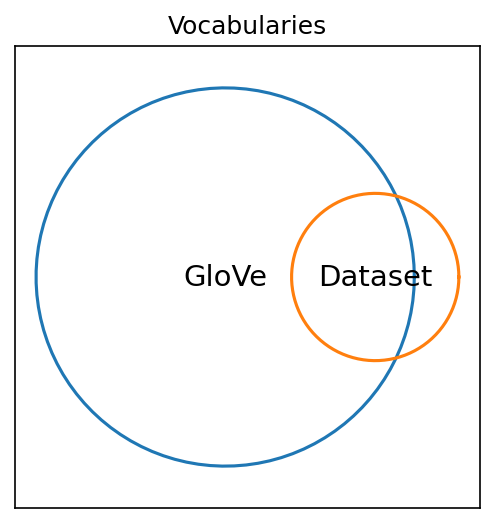

In [7]:
from torchtext.vocab import GloVe
glove = GloVe(name='6B', dim=100)
print("%i words in GloVe" % len(glove.itos))
print("%i words in the dataset" % len(dataset_vocab))
print("%i overlapping words" % len(dataset_vocab.intersection(set(glove.itos))))

import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

a = np.linspace(0, 2*np.pi, 100)
r1 = np.sqrt(len(glove.itos)/np.pi)
r2 = np.sqrt(len(dataset_vocab)/np.pi)
A = np.random.uniform(-r2, r2, size=(int(1000*(4/np.pi)), 2))
A = A[np.sqrt(np.sum(A**2, axis=1))<=r2, :]
p  = len(dataset_vocab.intersection(set(glove.itos)))/len(dataset_vocab)
def f(d):
    B = A.copy()
    B[:, 1] += d
    return np.abs(p-np.sum(np.sqrt(np.sum(B**2, axis=1))<=r1)/B.shape[0])

d = minimize_scalar(f, bounds=(r1-r2, r1+r2), method='bounded').x

plt.figure(figsize=(4, 4), dpi=150)
plt.plot(r1*np.cos(a), r1*np.sin(a))
plt.text(0, 0, "GloVe", fontsize=14, horizontalalignment='center', verticalalignment='center')
plt.plot(d+r2*np.cos(a), r2*np.sin(a))
plt.text(d, 0, "Dataset", fontsize=14, horizontalalignment='center', verticalalignment='center')
# A[:, 0] += d
# plt.scatter(A[:, 0], A[:, 1], s=3, c=np.sqrt(np.sum(A**2, axis=1))<=r1, marker='.', cmap='tab10')
plt.title("Vocabularies")
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.show()

The dataset vocabulary does not overlap completely with the embedding vocabulary.

In [8]:
embedding_vocab = dataset_vocab.intersection(set(glove.itos))

idx2token = ['<UNK>', '<PAD>']
idx2token.extend(embedding_vocab)

token2idx = {w:i for i, w in enumerate(idx2token)}

glove.unk_init = lambda _: torch.zeros(glove.dim)
embedding_vectors = torch.stack([glove[w] for w in idx2token])

embedding = nn.Embedding(num_embeddings=embedding_vectors.size(0),
                         embedding_dim=embedding_vectors.size(1),
                         padding_idx=token2idx['<PAD>']).from_pretrained(embedding_vectors)
embedding

Embedding(60352, 100)

In [9]:
class Encode(object):
    def __init__(self, token2idx):
        self._token2idx = token2idx
        self._vocab = set(token2idx.keys())

    def __call__(self, data):
        tokens, label = data['text'], data['label']
        tokens = [token if token in embedding_vocab else '<UNK>' for token in tokens]
        encoded = [token2idx[token] for token in tokens]
        return {'text': encoded, 'label': label}

class ToTensor(object):
    def __call__(self, data):
        text, label = data['text'], data['label']
        return {'text': torch.LongTensor(text),
                'label': torch.LongTensor([label])}

from torchvision import transforms

training_data = ParliamentData(training_raw,
                                transform=transforms.Compose([Tokenize(),
                                                              Encode(token2idx),
                                                              ToTensor()]))
print(training_data[0])

{'text': tensor([ 8341,  5271,  3275, 42688,  1540,   787, 43496,  4491, 20159, 24390,
        34105, 31479, 25192, 13861, 60271, 58362, 42998, 20159, 30072,  5271,
        41718, 29683, 26134, 42998, 20159, 35360, 13387, 35288,  3275, 42688,
         1540,   787, 43496, 33595,  3032, 20159, 25014, 16287, 20579, 36074,
        32963, 13956, 22483, 27089, 10284, 38404, 14522, 29683, 26134, 42998,
         5936,   383, 20159, 27589, 31479, 29965, 37634, 20579,  1534, 32963,
        10853, 51307, 35288,  3275, 42688, 36925,  1540,   787, 43496, 15046,
        20159, 59308, 25449,   688,  6176,   121, 31479,  3275, 25971,  1540,
          787, 43496, 32963,  9156,  5852, 13956, 22483, 53954,  2805,  3275,
        35288, 22671, 59083, 29683,  2836,  5271,  3275, 25971, 58826, 27089,
        30736, 16785, 35288]), 'label': tensor([0])}


In [10]:
# Collate function determine the shape of each batch in the loader
# This function returns a dictionary of {labels, text}, where values are a tensor of the length equal to the batch size
def collate_with_padding(batch):
    ret = {'label': torch.cat([sample['label'] for sample in batch])}
    max_length = np.max([sample['text'].size(0) for sample in batch])
    vectors = list()
    for sample in batch:
        # If a text is less than max length, add padding. Else, add the text
        if sample['text'].size(0) < max_length:
            vectors.append(torch.cat([sample['text'], torch.ones(max_length-sample['text'].size(0))*token2idx['<PAD>']]))
        else:
            vectors.append(sample['text'])

      # A value of the text is a list of tokens. stack them into a tensor of length equal to the batch size
    ret['text'] = torch.stack(vectors).long()
    return ret

dataloader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True, num_workers=0, collate_fn=collate_with_padding, pin_memory=True)
# d = list(dataloader)[0]


In [14]:
class PowerClassification(nn.Module):
    def __init__(self, embedding, n_epochs=20, learning_rate=1, verbose=False):
        super(PowerClassification, self).__init__()
        self.n_epochs_ = n_epochs
        self.verbose = verbose
        # Define layers
        self._embedding = embedding
        self._conv3 = nn.Sequential(nn.Conv1d(self._embedding.embedding_dim, 100, kernel_size=3, padding=0),
                                    nn.ReLU(),
                                    nn.AdaptiveMaxPool1d(1))
        self._conv4 = nn.Sequential(nn.Conv1d(self._embedding.embedding_dim, 100, kernel_size=4, padding=0),
                                    nn.ReLU(),
                                    nn.AdaptiveMaxPool1d(1))
        self._conv5 = nn.Sequential(nn.Conv1d(self._embedding.embedding_dim, 100, kernel_size=5, padding=0),
                                    nn.ReLU(),
                                    nn.AdaptiveMaxPool1d(1))
        self._dropout = nn.Dropout(0.5)
        self._fc = nn.Sequential(nn.Linear(3*100, 2),
                                nn.LogSoftmax(dim=1))
        # Define optimiser and loss
        self.learning_rate_ = learning_rate
        self.optimizer_ = torch.optim.SGD(self.parameters(), lr=self.learning_rate_)
        self.loss_function_ = nn.NLLLoss()
        # For making nice plots
        self.training_loss_ = list()
        self.training_accuracy_ = list()

        if torch.cuda.is_available():
            self.to('cuda')


    def forward(self, X):
        # """Forward pass, this is used for making predictions."""
        x = self._embedding(X)
        x = x.transpose(1, 2)
        c3 = self._conv3(x)
        c4 = self._conv4(x)
        c5 = self._conv5(x)
        x = torch.cat([c3, c4, c5], dim=1)
        x = x.view(x.size(0), -1)
        x = self._dropout(x)
        x = self._fc(x)
        return x


    def fit(self, X, y=None):
        """Train the model"""
        for epoch in range(self.n_epochs_):
            if isinstance(X, torch.utils.data.dataloader.DataLoader):
                for batch in tqdm(X, desc="Training epoch %i" % epoch):
                    self._fit(batch['text'], batch['label'])
            else:
                self._fit(X, y)

            if self.verbose:
                if self.n_epochs_ < 50 or (epoch % 50) == 0:
                    print("Epoch %2i: Loss %.7f" % (epoch, self._loss.item()))


    def _fit(self, X, y):
        """A single step in the training"""
        if torch.cuda.is_available():
            X = X.cuda()
            y = y.cuda()

        self.zero_grad()              # Reset gradients
        forward_pass_output = self(X) # Forward pass
        self._loss = self.loss_function_(forward_pass_output, y) # Calculate loss
        self._loss.backward()         # Backward pass
        self.optimizer_.step()        # Run the optimizer one step
        # Store values for user feedback
        self.training_loss_.append(self._loss.item())
        self.training_accuracy_.append(self.score(X, y))


    def predict(self, X):
        """Predict labels"""
        return np.asarray(np.argmax(self.predict_proba(X), axis=1), dtype=int)


    def predict_proba(self, X):
        """Predict label probabilities"""
        if torch.cuda.is_available():
            X = X.cuda()
        with torch.no_grad():         # Disable gradient calculations
            model.eval()                # Disable dropout
            x = self(X)                 # Forward pass without dropout
            model.train()               # Enable dropout again, we need it during training

            if torch.cuda.is_available():
                x = x.cpu()

        return np.exp(x.detach().numpy())


    def score(self, X, y):
        """Get the accuracy of the model given the data"""
        if torch.cuda.is_available():
            y = y.cpu()
        return np.sum(self.predict(X)==y.numpy())/len(y)

model = PowerClassification(embedding=embedding, n_epochs=3, verbose=True, learning_rate=.1)

In [15]:
model.fit(dataloader)

Training epoch 0: 100%|██████████| 556/556 [00:57<00:00,  9.74it/s]


Epoch  0: Loss 0.5848358


Training epoch 1: 100%|██████████| 556/556 [00:53<00:00, 10.47it/s]


Epoch  1: Loss 0.4843262


Training epoch 2: 100%|██████████| 556/556 [00:53<00:00, 10.31it/s]

Epoch  2: Loss 0.4550712


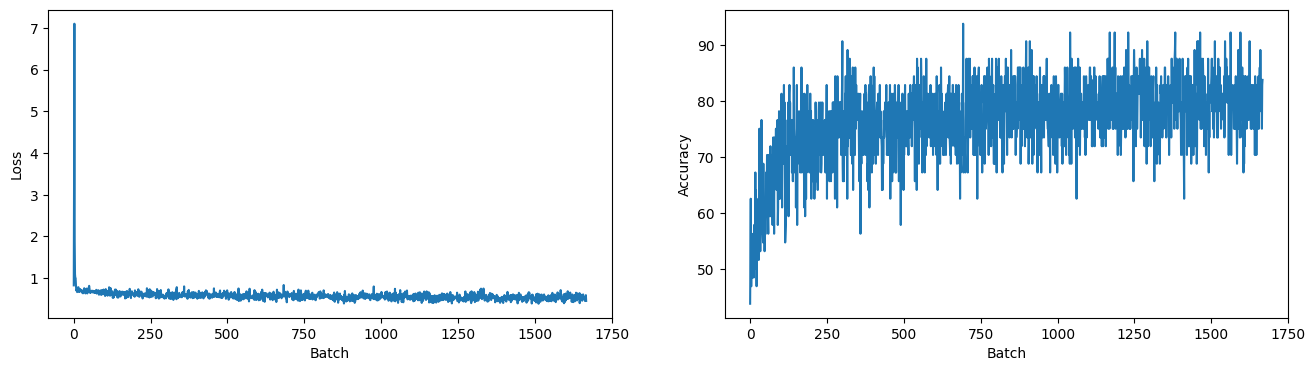

In [16]:
batches = int(np.ceil(len(training_data)/dataloader.batch_size))

fig = plt.figure(figsize=(16, 4))
ax = fig.subplots(1, 2)
ax[0].plot(model.training_loss_)
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Batch")
ax[1].plot(100*np.asarray(model.training_accuracy_))
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Batch")
fig.show()

In [17]:
for p in model.parameters():
  print(p.shape)

torch.Size([60352, 100])
torch.Size([100, 100, 3])
torch.Size([100])
torch.Size([100, 100, 4])
torch.Size([100])
torch.Size([100, 100, 5])
torch.Size([100])
torch.Size([2, 300])
torch.Size([2])


In [18]:
test_data = ParliamentData(test_raw,
                            transform=transforms.Compose([Tokenize(),
                                                          Encode(token2idx),
                                                          ToTensor()]))
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=64, num_workers=0,
                                               collate_fn=collate_with_padding)
accuracy = np.average([model.score(batch['text'], batch['label']) for batch in tqdm(test_data_loader, desc="Calculating test set accuracy")])
print("Test set accuracy is %.1f%%" % (100*accuracy))

Calculating test set accuracy: 100%|██████████| 141/141 [00:08<00:00, 15.82it/s]

Test set accuracy is 75.6%
